# Facial Recognition: Implementing for Identification of Celebrity Faces

In this notebook we followed a few resources and a integrated a face_recognition pre-trained model from deeplearning.ai to implement a deep facial recognition program through facenet concepts we learned in class. The model maps facial images of celebrities into 128 dimentional encodings, and we then integrated this to detect faces, identify the peerson and classify if the face is who our desired person is. 

Throughout this part of our project, our process included using inception block for model training, locating faces, transitioning an image from our dataset to an encoding, verifying our classifications, and then testing the recognition abilities of our final product by distiguishing who is Matt Damon! Overall poolling information from many sources resulted in a successful facenet facial recognition program! Below are many of the sites we used while developing this.

Useful sites we used included:
* https://www.youtube.com/watch?v=LKispFFQ5GU
* https://towardsdatascience.com/building-face-recognition-model-under-30-minutes-2d1b0ef72fd
* https://github.com/nicknochnack/FaceRecognition
* https://github.com/ageitgey/face_recognition
* https://github.com/zeynepCankara/Face-Recognition-Tensorflow
* https://github.com/4uiiurz1/keras-arcface
*  https://github.com/iwantooxxoox/Keras-OpenFace/blob/master/utils.py




In [1]:
!pip install cmake     
!pip install face_recognition #Pretrained model is within here

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
from fr_utils import *
import h5py
from inception_blocks import *
import matplotlib.pyplot as plt
import face_recognition
from PIL import Image


%matplotlib inline
%load_ext autoreload
%autoreload 2

#np.set_printoptions(threshold=np.nan)

We begin by establishing an inception block that is used as a goto architecture for the rest of this notebook when passing through layers for training for the recognition. The recognition funciton is then integrated where we integrate the inception model for facenet. This functionality, as we have seen throughout the semseter, passes through the image data thorugh the convolutional neural network with correct initial sizing, and then outputs the model that we will use. 

In [2]:
import tensorflow as tf
import numpy as np
import os
from numpy import genfromtxt
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
#import fr_utils
from tensorflow.keras.layers import Lambda, Flatten, Dense

def inception_block_1a(X):
    X_3x3 = Conv2D(96, (1, 1), data_format='channels_first', name ='inception_3a_3x3_conv1')(X)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name = 'inception_3a_3x3_bn1')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)
    X_3x3 = ZeroPadding2D(padding=(1, 1), data_format='channels_first')(X_3x3)
    X_3x3 = Conv2D(128, (3, 3), data_format='channels_first', name='inception_3a_3x3_conv2')(X_3x3)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_3x3_bn2')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)
    
    X_5x5 = Conv2D(16, (1, 1), data_format='channels_first', name='inception_3a_5x5_conv1')(X)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_5x5_bn1')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)
    X_5x5 = ZeroPadding2D(padding=(2, 2), data_format='channels_first')(X_5x5)
    X_5x5 = Conv2D(32, (5, 5), data_format='channels_first', name='inception_3a_5x5_conv2')(X_5x5)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_5x5_bn2')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)

    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_pool = Conv2D(32, (1, 1), data_format='channels_first', name='inception_3a_pool_conv')(X_pool)
    X_pool = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_pool_bn')(X_pool)
    X_pool = Activation('relu')(X_pool)
    X_pool = ZeroPadding2D(padding=((3, 4), (3, 4)), data_format='channels_first')(X_pool)

    X_1x1 = Conv2D(64, (1, 1), data_format='channels_first', name='inception_3a_1x1_conv')(X)
    X_1x1 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_1x1_bn')(X_1x1)
    X_1x1 = Activation('relu')(X_1x1)
        
    inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=1)

    return inception

def inception_block_1b(X):
    X_3x3 = Conv2D(96, (1, 1), data_format='channels_first', name='inception_3b_3x3_conv1')(X)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_3x3_bn1')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)
    X_3x3 = ZeroPadding2D(padding=(1, 1), data_format='channels_first')(X_3x3)
    X_3x3 = Conv2D(128, (3, 3), data_format='channels_first', name='inception_3b_3x3_conv2')(X_3x3)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_3x3_bn2')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)

    X_5x5 = Conv2D(32, (1, 1), data_format='channels_first', name='inception_3b_5x5_conv1')(X)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_5x5_bn1')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)
    X_5x5 = ZeroPadding2D(padding=(2, 2), data_format='channels_first')(X_5x5)
    X_5x5 = Conv2D(64, (5, 5), data_format='channels_first', name='inception_3b_5x5_conv2')(X_5x5)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_5x5_bn2')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)

    X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_first')(X)
    X_pool = Conv2D(64, (1, 1), data_format='channels_first', name='inception_3b_pool_conv')(X_pool)
    X_pool = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_pool_bn')(X_pool)
    X_pool = Activation('relu')(X_pool)
    X_pool = ZeroPadding2D(padding=(4, 4), data_format='channels_first')(X_pool)

    X_1x1 = Conv2D(64, (1, 1), data_format='channels_first', name='inception_3b_1x1_conv')(X)
    X_1x1 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_1x1_bn')(X_1x1)
    X_1x1 = Activation('relu')(X_1x1)

    inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=1)

    return inception

def inception_block_1c(X):
    X_3x3 = fr_utils.conv2d_bn(X,
                           layer='inception_3c_3x3',
                           cv1_out=128,
                           cv1_filter=(1, 1),
                           cv2_out=256,
                           cv2_filter=(3, 3),
                           cv2_strides=(2, 2),
                           padding=(1, 1))

    X_5x5 = fr_utils.conv2d_bn(X,
                           layer='inception_3c_5x5',
                           cv1_out=32,
                           cv1_filter=(1, 1),
                           cv2_out=64,
                           cv2_filter=(5, 5),
                           cv2_strides=(2, 2),
                           padding=(2, 2))

    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_pool = ZeroPadding2D(padding=((0, 1), (0, 1)), data_format='channels_first')(X_pool)

    inception = concatenate([X_3x3, X_5x5, X_pool], axis=1)

    return inception

def inception_block_2a(X):
    X_3x3 = fr_utils.conv2d_bn(X,
                           layer='inception_4a_3x3',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           cv2_out=192,
                           cv2_filter=(3, 3),
                           cv2_strides=(1, 1),
                           padding=(1, 1))
    X_5x5 = fr_utils.conv2d_bn(X,
                           layer='inception_4a_5x5',
                           cv1_out=32,
                           cv1_filter=(1, 1),
                           cv2_out=64,
                           cv2_filter=(5, 5),
                           cv2_strides=(1, 1),
                           padding=(2, 2))

    X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_first')(X)
    X_pool = fr_utils.conv2d_bn(X_pool,
                           layer='inception_4a_pool',
                           cv1_out=128,
                           cv1_filter=(1, 1),
                           padding=(2, 2))
    X_1x1 = fr_utils.conv2d_bn(X,
                           layer='inception_4a_1x1',
                           cv1_out=256,
                           cv1_filter=(1, 1))
    inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=1)

    return inception

def inception_block_2b(X):
    X_3x3 = fr_utils.conv2d_bn(X,
                           layer='inception_4e_3x3',
                           cv1_out=160,
                           cv1_filter=(1, 1),
                           cv2_out=256,
                           cv2_filter=(3, 3),
                           cv2_strides=(2, 2),
                           padding=(1, 1))
    X_5x5 = fr_utils.conv2d_bn(X,
                           layer='inception_4e_5x5',
                           cv1_out=64,
                           cv1_filter=(1, 1),
                           cv2_out=128,
                           cv2_filter=(5, 5),
                           cv2_strides=(2, 2),
                           padding=(2, 2))
    
    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_pool = ZeroPadding2D(padding=((0, 1), (0, 1)), data_format='channels_first')(X_pool)

    inception = concatenate([X_3x3, X_5x5, X_pool], axis=1)

    return inception

def inception_block_3a(X):
    X_3x3 = fr_utils.conv2d_bn(X,
                           layer='inception_5a_3x3',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           cv2_out=384,
                           cv2_filter=(3, 3),
                           cv2_strides=(1, 1),
                           padding=(1, 1))
    X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_first')(X)
    X_pool = fr_utils.conv2d_bn(X_pool,
                           layer='inception_5a_pool',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           padding=(1, 1))
    X_1x1 = fr_utils.conv2d_bn(X,
                           layer='inception_5a_1x1',
                           cv1_out=256,
                           cv1_filter=(1, 1))

    inception = concatenate([X_3x3, X_pool, X_1x1], axis=1)

    return inception

def inception_block_3b(X):
    X_3x3 = fr_utils.conv2d_bn(X,
                           layer='inception_5b_3x3',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           cv2_out=384,
                           cv2_filter=(3, 3),
                           cv2_strides=(1, 1),
                           padding=(1, 1))
    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_pool = fr_utils.conv2d_bn(X_pool,
                           layer='inception_5b_pool',
                           cv1_out=96,
                           cv1_filter=(1, 1))
    X_pool = ZeroPadding2D(padding=(1, 1), data_format='channels_first')(X_pool)

    X_1x1 = fr_utils.conv2d_bn(X,
                           layer='inception_5b_1x1',
                           cv1_out=256,
                           cv1_filter=(1, 1))
    inception = concatenate([X_3x3, X_pool, X_1x1], axis=1)

    return inception

def faceRecoModel(input_shape):
    """
    Implementation of the Inception model used for FaceNet
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
        
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # First Block
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1')(X)
    X = BatchNormalization(axis = 1, name = 'bn1')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)
    X = MaxPooling2D((3, 3), strides = 2)(X)
    
    # Second Block
    X = Conv2D(64, (1, 1), strides = (1, 1), name = 'conv2')(X)
    X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)

    # Second Block
    X = Conv2D(192, (3, 3), strides = (1, 1), name = 'conv3')(X)
    X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)
    X = MaxPooling2D(pool_size = 3, strides = 2)(X)
    
    # Inception 1: a/b/c
    X = inception_block_1a(X)
    X = inception_block_1b(X)
    X = inception_block_1c(X)
    
    # Inception 2: a/b
    X = inception_block_2a(X)
    X = inception_block_2b(X)
    
    # Inception 3: a/b
    X = inception_block_3a(X)
    X = inception_block_3b(X)
    
    # Top layer
    X = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), data_format='channels_first')(X)
    X = Flatten()(X)
    X = Dense(128, name='dense_layer')(X)
    
    # L2 normalization
    X = Lambda(lambda  x: K.l2_normalize(x,axis=1))(X)

    # Create model instance
    model = Model(inputs = X_input, outputs = X, name='FaceRecoModel')
        
    return model


Below we print the sumamry of the model just for clarity and checking the status of the model.

In [3]:

FRmodel = faceRecoModel(input_shape=(3, 96, 96))

In [4]:

FRmodel.summary()

Model: "FaceRecoModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 96, 96)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 3, 102, 102)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 64, 48, 48)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 bn1 (BatchNormalization)       (None, 64, 48, 48)   256         ['conv1[0][0]']                  
                                                                                      

Using a triplet loss funciton we found at https://github.com/zeynepCankara/Face-Recognition-Tensorflow, we are now incoorperating the distictive methods of deep facial networks where we define the anchor as the picture of someone's face, the "positive" as another picture of the same person, and the "negative" as a picture of a person that is different than the person that is in the anchor. By computing the "distance" between the anchor and the positive vs the anchor and the negative, we can create a encoded metric for determining whether or not we think the two faces are the same person. Specifically, a resulting encoded difference (ie loss) should be small if the two faces are the same, and large if they are different.

In [5]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    # (encoding) distance between the anchor and the positive
    pos_dist = tf.square(tf.subtract(anchor, positive)) 
    # (encoding) distance between the anchor and the negative
    neg_dist = tf.square(tf.subtract(anchor, negative)) 
    # Subtracting the two previous distances and adding an alpha.
    basic_loss = tf.add(tf.reduce_sum(tf.subtract(pos_dist, neg_dist)), alpha)
    # Taking the maximum of basic_loss and 0.0. Summing over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))
    
    return loss

Now integrating code with weights previously trained in facial_recognition. We can then preprosses the anchor image with resizing, and predict the trained model through standard our embedding function.

In [6]:


_FLOATX = 'float32'

def variable(value, dtype=_FLOATX, name=None):
    v = tf.Variable(np.asarray(value, dtype=dtype), name=name)
    _get_session().run(v.initializer)
    return v

def shape(x):
    return x.get_shape()

def square(x):
    return tf.square(x)

def zeros(shape, dtype=_FLOATX, name=None):
    return variable(np.zeros(shape), dtype, name)

def concatenate(tensors, axis=-1):
    if axis < 0:
        axis = axis % len(tensors[0].get_shape())
    return tf.concat(axis, tensors)

def LRN2D(x):
    return tf.nn.lrn(x, alpha=1e-4, beta=0.75)

def conv2d_bn(x,
              layer=None,
              cv1_out=None,
              cv1_filter=(1, 1),
              cv1_strides=(1, 1),
              cv2_out=None,
              cv2_filter=(3, 3),
              cv2_strides=(1, 1),
              padding=None):
    num = '' if cv2_out == None else '1'
    tensor = Conv2D(cv1_out, cv1_filter, strides=cv1_strides, data_format='channels_first', name=layer+'_conv'+num)(x)
    tensor = BatchNormalization(axis=1, epsilon=0.00001, name=layer+'_bn'+num)(tensor)
    tensor = Activation('relu')(tensor)
    if padding == None:
        return tensor
    tensor = ZeroPadding2D(padding=padding, data_format='channels_first')(tensor)
    if cv2_out == None:
        return tensor
    tensor = Conv2D(cv2_out, cv2_filter, strides=cv2_strides, data_format='channels_first', name=layer+'_conv'+'2')(tensor)
    tensor = BatchNormalization(axis=1, epsilon=0.00001, name=layer+'_bn'+'2')(tensor)
    tensor = Activation('relu')(tensor)
    return tensor

WEIGHTS = [
  'conv1', 'bn1', 'conv2', 'bn2', 'conv3', 'bn3',
  'inception_3a_1x1_conv', 'inception_3a_1x1_bn',
  'inception_3a_pool_conv', 'inception_3a_pool_bn',
  'inception_3a_5x5_conv1', 'inception_3a_5x5_conv2', 'inception_3a_5x5_bn1', 'inception_3a_5x5_bn2',
  'inception_3a_3x3_conv1', 'inception_3a_3x3_conv2', 'inception_3a_3x3_bn1', 'inception_3a_3x3_bn2',
  'inception_3b_3x3_conv1', 'inception_3b_3x3_conv2', 'inception_3b_3x3_bn1', 'inception_3b_3x3_bn2',
  'inception_3b_5x5_conv1', 'inception_3b_5x5_conv2', 'inception_3b_5x5_bn1', 'inception_3b_5x5_bn2',
  'inception_3b_pool_conv', 'inception_3b_pool_bn',
  'inception_3b_1x1_conv', 'inception_3b_1x1_bn',
  'inception_3c_3x3_conv1', 'inception_3c_3x3_conv2', 'inception_3c_3x3_bn1', 'inception_3c_3x3_bn2',
  'inception_3c_5x5_conv1', 'inception_3c_5x5_conv2', 'inception_3c_5x5_bn1', 'inception_3c_5x5_bn2',
  'inception_4a_3x3_conv1', 'inception_4a_3x3_conv2', 'inception_4a_3x3_bn1', 'inception_4a_3x3_bn2',
  'inception_4a_5x5_conv1', 'inception_4a_5x5_conv2', 'inception_4a_5x5_bn1', 'inception_4a_5x5_bn2',
  'inception_4a_pool_conv', 'inception_4a_pool_bn',
  'inception_4a_1x1_conv', 'inception_4a_1x1_bn',
  'inception_4e_3x3_conv1', 'inception_4e_3x3_conv2', 'inception_4e_3x3_bn1', 'inception_4e_3x3_bn2',
  'inception_4e_5x5_conv1', 'inception_4e_5x5_conv2', 'inception_4e_5x5_bn1', 'inception_4e_5x5_bn2',
  'inception_5a_3x3_conv1', 'inception_5a_3x3_conv2', 'inception_5a_3x3_bn1', 'inception_5a_3x3_bn2',
  'inception_5a_pool_conv', 'inception_5a_pool_bn',
  'inception_5a_1x1_conv', 'inception_5a_1x1_bn',
  'inception_5b_3x3_conv1', 'inception_5b_3x3_conv2', 'inception_5b_3x3_bn1', 'inception_5b_3x3_bn2',
  'inception_5b_pool_conv', 'inception_5b_pool_bn',
  'inception_5b_1x1_conv', 'inception_5b_1x1_bn',
  'dense_layer'
]

conv_shape = {
  'conv1': [64, 3, 7, 7],
  'conv2': [64, 64, 1, 1],
  'conv3': [192, 64, 3, 3],
  'inception_3a_1x1_conv': [64, 192, 1, 1],
  'inception_3a_pool_conv': [32, 192, 1, 1],
  'inception_3a_5x5_conv1': [16, 192, 1, 1],
  'inception_3a_5x5_conv2': [32, 16, 5, 5],
  'inception_3a_3x3_conv1': [96, 192, 1, 1],
  'inception_3a_3x3_conv2': [128, 96, 3, 3],
  'inception_3b_3x3_conv1': [96, 256, 1, 1],
  'inception_3b_3x3_conv2': [128, 96, 3, 3],
  'inception_3b_5x5_conv1': [32, 256, 1, 1],
  'inception_3b_5x5_conv2': [64, 32, 5, 5],
  'inception_3b_pool_conv': [64, 256, 1, 1],
  'inception_3b_1x1_conv': [64, 256, 1, 1],
  'inception_3c_3x3_conv1': [128, 320, 1, 1],
  'inception_3c_3x3_conv2': [256, 128, 3, 3],
  'inception_3c_5x5_conv1': [32, 320, 1, 1],
  'inception_3c_5x5_conv2': [64, 32, 5, 5],
  'inception_4a_3x3_conv1': [96, 640, 1, 1],
  'inception_4a_3x3_conv2': [192, 96, 3, 3],
  'inception_4a_5x5_conv1': [32, 640, 1, 1,],
  'inception_4a_5x5_conv2': [64, 32, 5, 5],
  'inception_4a_pool_conv': [128, 640, 1, 1],
  'inception_4a_1x1_conv': [256, 640, 1, 1],
  'inception_4e_3x3_conv1': [160, 640, 1, 1],
  'inception_4e_3x3_conv2': [256, 160, 3, 3],
  'inception_4e_5x5_conv1': [64, 640, 1, 1],
  'inception_4e_5x5_conv2': [128, 64, 5, 5],
  'inception_5a_3x3_conv1': [96, 1024, 1, 1],
  'inception_5a_3x3_conv2': [384, 96, 3, 3],
  'inception_5a_pool_conv': [96, 1024, 1, 1],
  'inception_5a_1x1_conv': [256, 1024, 1, 1],
  'inception_5b_3x3_conv1': [96, 736, 1, 1],
  'inception_5b_3x3_conv2': [384, 96, 3, 3],
  'inception_5b_pool_conv': [96, 736, 1, 1],
  'inception_5b_1x1_conv': [256, 736, 1, 1],
}

def load_weights_from_FaceNet(FRmodel):
    # Load weights from csv files (which was exported from Openface torch model)
    weights = WEIGHTS
    weights_dict = load_weights()

    # Set layer weights of the model
    for name in weights:
        if FRmodel.get_layer(name) != None:
            FRmodel.get_layer(name).set_weights(weights_dict[name])
        elif model.get_layer(name) != None:
            model.get_layer(name).set_weights(weights_dict[name])

def load_weights():
    # Set weights path
    dirPath = './weights'
    fileNames = filter(lambda f: not f.startswith('.'), os.listdir(dirPath))
    paths = {}
    weights_dict = {}

    for n in fileNames:
        paths[n.replace('.csv', '')] = dirPath + '/' + n

    for name in WEIGHTS:
        if 'conv' in name:
            conv_w = genfromtxt(paths[name + '_w'], delimiter=',', dtype=None)
            conv_w = np.reshape(conv_w, conv_shape[name])
            conv_w = np.transpose(conv_w, (2, 3, 1, 0))
            conv_b = genfromtxt(paths[name + '_b'], delimiter=',', dtype=None)
            weights_dict[name] = [conv_w, conv_b]     
        elif 'bn' in name:
            bn_w = genfromtxt(paths[name + '_w'], delimiter=',', dtype=None)
            bn_b = genfromtxt(paths[name + '_b'], delimiter=',', dtype=None)
            bn_m = genfromtxt(paths[name + '_m'], delimiter=',', dtype=None)
            bn_v = genfromtxt(paths[name + '_v'], delimiter=',', dtype=None)
            weights_dict[name] = [bn_w, bn_b, bn_m, bn_v]
        elif 'dense' in name:
            dense_w = genfromtxt(dirPath+'/dense_w.csv', delimiter=',', dtype=None)
            dense_w = np.reshape(dense_w, (128, 736))
            dense_w = np.transpose(dense_w, (1, 0))
            dense_b = genfromtxt(dirPath+'/dense_b.csv', delimiter=',', dtype=None)
            weights_dict[name] = [dense_w, dense_b]

    return weights_dict


def load_dataset():
    train_dataset = h5py.File('datasets/train_happy.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_happy.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

def pre_process_image(img, image_size):
    height, width, channels = image_size
    img = cv2.resize(img, dsize=(height, width))
    return img

def img_to_encoding(image_path, model):
    img1 = cv2.imread(image_path, 1)
    image_size = (96, 96, 3)
    img1 = pre_process_image(img1, image_size)
        
    img = img1[...,::-1]
    img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
    x_train = np.array([img])
    embedding = model.predict_on_batch(x_train)
    return embedding



In [7]:
# Compile optimization of model...
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

In [8]:

def pre_process_image(img, image_size):
    height, width, channels = image_size
    img = cv2.resize(img, dsize=(height, width))
    return img

Before identifying faces, the face_recognition library that we used to find pretrained weights to our model, also contains classes for integrating face locating funcitonality, so we followed the resource for implementing here. This funciton is able to draw the necessary bounding box of interest around the face of the anchor to improve accuracy of the overall recongition process.

In [9]:
def find_face_locations(image_path):

    image = face_recognition.load_image_file(image_path)
    
    #Test: print("Shape of the image: " + str(image.shape))
    
    face_locations = face_recognition.face_locations(image)
    for face_location in face_locations:
        top, right, bottom, left = face_location
        print("A face is located at pixel location Top: {}, Left: {}, Bottom: {}, Right: {}".format(top, left, bottom, right))
    return face_locations, image

Now to embed the model, we run a forward propogation of our inception model on our anchor image to compute the embeddings of all the people in the image as a vector (so we can manage more than one face).


In [10]:

def face_img_to_encoding(image_path, model):

    face_locations, image = find_face_locations(image_path)
    embeddings = []
    for face_location in face_locations:

        top, right, bottom, left = face_location

        face_image = image[top:bottom, left:right]

        image_size = (96, 96, 3)
        img = pre_process_image(face_image, image_size) #pre-process
        img = img[...,::-1]
        img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
        x_train = np.array([img])
        embedding = model.predict(x_train)
        embeddings.append(embedding)
        
    return embeddings

Now for the fun part of testing what we have made. Using the photos of celebrities we have access to (we call where we get them from a database just so cause we had to upload this to collab which was a bit of a process but these are images from our computers and could be photos of anyones face!), we first locate the faces. 

In [11]:
# Create a initial database for identifying people
database = {}
database["leonardo dicaprio"] = face_img_to_encoding("./images/dicaprio.jpg", FRmodel)
database["brad pitt"] = face_img_to_encoding("./images/bradPitt1.jpg", FRmodel)
database["matt damon"] = face_img_to_encoding("./images/mattDamon.jpg", FRmodel)
database["unknown"] = face_img_to_encoding("./images/unknown.jpg", FRmodel)

A face is located at pixel location Top: 142, Left: 82, Bottom: 409, Right: 349
A face is located at pixel location Top: 66, Left: 56, Bottom: 156, Right: 145
A face is located at pixel location Top: 167, Left: 241, Bottom: 390, Right: 464
A face is located at pixel location Top: 56, Left: 91, Bottom: 163, Right: 199


While embedding the image we can check the status of our fucntionality here by seeing the anchor photo then watching the resulting data of embedding the image.

A face is located at pixel location Top: 142, Left: 82, Bottom: 409, Right: 349
[array([[ 1.78886596e-02,  5.65267801e-02,  2.81435605e-02,
        -3.98352668e-02, -4.05347124e-02,  2.42677610e-02,
        -1.41860098e-02,  1.34195819e-01,  1.05123587e-01,
         8.81081680e-04,  1.01466797e-01, -8.59746262e-02,
         3.61333750e-02,  1.36936111e-02,  1.07706048e-01,
        -9.76482332e-02,  1.09040841e-01, -3.92249748e-02,
        -1.59159990e-03,  8.56322348e-02, -6.27494184e-03,
        -7.53135681e-02,  4.57189046e-02,  1.09545626e-01,
         1.58418436e-02, -6.24674074e-02,  7.43720680e-02,
        -4.84099286e-03,  8.69201794e-02, -1.08194448e-01,
         1.53262332e-01, -1.19411446e-01,  1.46491244e-01,
         6.78102821e-02,  1.05313165e-03,  6.50675818e-02,
         1.28551424e-01,  2.16996819e-01, -6.92940950e-02,
        -1.01205632e-01,  2.92130955e-03, -3.01705282e-02,
        -7.62766972e-02, -1.59512536e-04, -5.51991649e-02,
        -7.61035308e-02, -2.717373

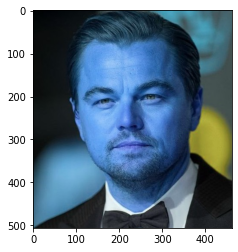

In [12]:

embedding = face_img_to_encoding("./images/dicaprio.jpg", FRmodel)
img = cv2.imread("./images/dicaprio.jpg")
#Visualize the image
plt.imshow(img)

print(embedding)

Now to perform the final face verification we are matching facial data between two images containing the same or different people. By classification, and name association we are able to identify if the photo is of leonardo decaprio, or someone else through the face verify() funciton. For the classification, we have set the threshold of verifying a faces identity to 75% confidence.

In [13]:
def verify(image_path, identity, database, model):

    encodings = face_img_to_encoding(image_path, FRmodel)

    for encoding in encodings:
        
        dist = np.linalg.norm(encoding - database[identity])# Compute distancee 
        # Match if dist < 0.75
        if dist < 0.75:
            print(str(identity) + ", verified.")
            match = True
        else:
            print("This is not " + str(identity) + "!!!")
            match = False
    return dist, match

Running the program with a facial image of leonardo decaprio seeing if it is "Matt Damon". This obviously should not be verified.

In [14]:
verify("./images/dicaprio.jpg", "matt damon", database, FRmodel)

A face is located at pixel location Top: 142, Left: 82, Bottom: 409, Right: 349
This is not matt damon!!!


(0.94035983, False)

Running the program with a facial image of leonardo decaprio seeing if it is "Matt Damon". This should be verified.


In [15]:
verify("./images/mattDamon1.jpg", "matt damon", database, FRmodel)

A face is located at pixel location Top: 98, Left: 98, Bottom: 253, Right: 253
matt damon, verified.


(0.7425691, True)

Now expanding this process to identify a person without needing to provide the identity (instead of matching with an anchor photo of the desired identity in our "database"). To do this we compute the target encoding of the image from image_path and then find the encoding from the database that has smallest distance with the target encoding. 

In [20]:
def recognize(image_path, database, model):
    encodings = face_img_to_encoding(image_path, model)
    identities = []
    unknown_encodings = []
    for encoding in encodings: 
        min_dist = 100
        for (name, db_encodings) in database.items():
            
            for db_enc in db_encodings:
        
                dist = np.linalg.norm(encoding - db_enc)

                if dist < min_dist:
                    min_dist = dist
                    identity = name
                
            if min_dist > 0.8:
                print("Not in the database.")
   
                unknown_encodings.append(encoding)
                
            else:
                if identity not in identities and identity != "unknown":
                    print ("This is " + str(identity) + ", the distance is " + str(min_dist))
                    identities.append(identity)
                    face_encodings = database[str(identity)]
                    face_encodings.append(encoding)
                    database[str(identity)] = face_encodings
    
    for encoding in unknown_encodings:
        unknown = database["unknown"]
        unknown.append(encoding)
        database["unknown"] = unknown
        
    return identities

Finally, we test this classification that does not require 1 to 1 comparison of two facial images to identify matt damon.

In [21]:
recognize("./images/mattDamon1.jpg", database, FRmodel)

A face is located at pixel location Top: 98, Left: 98, Bottom: 253, Right: 253
Not in the database.
Not in the database.
This is matt damon, the distance is 0.0


['matt damon']